<a href="https://colab.research.google.com/github/chungngoc/VMI_2024/blob/main/TP_SelfSupervisedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d cs294-158-ssl ]; then rm -Rf cs294-158-ssl; fi
!git clone https://github.com/ckurtz/cs294-158-ssl
!pip install cs294-158-ssl/

import os
os.chdir('cs294-158-ssl')

Cloning into 'cs294-158-ssl'...
remote: Enumerating objects: 611, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 611 (delta 115), reused 119 (delta 53), pack-reused 422 (from 1)
Receiving objects: 100% (611/611), 3.11 MiB | 16.03 MiB/s, done.
Resolving deltas: 100% (424/424), done.
Processing ./cs294-158-ssl
  Preparing metadata (setup.py) ... done
  Created wheel for deepul_helper: filename=deepul_helper-0.1.0-py3-none-any.whl size=25300 sha256=295e5ebf8d7f0eec07506659387c257bea407aada2ab205dd06524a37ead3503
  Stored in directory: /root/.cache/pip/wheels/e3/df/97/281e32d717214451862e0e558746de423b9ef530b7376421e2
Successfully built deepul_helper


Download the necessary pretrained models

In [2]:
!wget https://camille-kurtz.com/teaching/data.zip
!unzip -qq data.zip
!rm data.zip

--2024-11-10 23:45:49--  https://camille-kurtz.com/teaching/data.zip
Resolving camille-kurtz.com (camille-kurtz.com)... 213.186.33.3
Connecting to camille-kurtz.com (camille-kurtz.com)|213.186.33.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4227668031 (3.9G) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   3.94G  29.1MB/s    in 2m 28s  

2024-11-10 23:48:18 (27.2 MB/s) - ‘data.zip’ saved [4227668031/4227668031]



In [ ]:
!wget https://camille-kurtz.com/teaching/results.zip
!unzip -qq results.zip
!rm results.zip

--2024-11-10 22:52:24--  https://camille-kurtz.com/teaching/results.zip
Resolving camille-kurtz.com (camille-kurtz.com)... 213.186.33.3
Connecting to camille-kurtz.com (camille-kurtz.com)|213.186.33.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2636425194 (2.5G) [application/zip]
Saving to: ‘results.zip’

results.zip         100%[===================>]   2.46G  19.1MB/s    in 2m 11s  

2024-11-10 22:54:36 (19.2 MB/s) - ‘results.zip’ saved [2636425194/2636425194]



# Comparer les performances de classification de l’ensemble des modèles

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from deepul_helper.demos import evaluate_classifier, load_model_and_data
%matplotlib inline
torch.cuda.is_available()

True

In [ ]:
train_scores, test_scores = [], []

type_models = ['context_encoder', 'rotation', 'simclr']
for type_model in type_models:
    model, linear_classifier, train_loader, test_loader = load_model_and_data(type_model)
    train_acc1, train_acc5 = evaluate_classifier(model, linear_classifier, train_loader)
    train_scores.append((train_acc1, train_acc5))

    test_acc1, test_acc5 = evaluate_classifier(model, linear_classifier, test_loader)
    test_scores.append((test_acc1, test_acc5))

print(train_scores)
print(test_scores)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/content/cs294-158-ssl/deepul_helper/demos.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickli

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[(53.236, 94.094), (79.636, 99.084), (89.996, 99.504)]
[(45.77, 90.29), (79.91, 99.12), (92.84, 99.86)]


In [ ]:
train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

test_acc = {
    'context_encoder': test_scores[0],
    'rotation': test_scores[1],
    'simclr': test_scores[2]
}

index_labels = ['Top-1 Accuracy', 'Top-5 Accuracy']
df_test = pd.DataFrame(test_acc, index = index_labels)
print(df_test)


                context_encoder  rotation  simclr
Top-1 Accuracy            45.77     79.91   92.84
Top-5 Accuracy            90.29     99.12   99.86


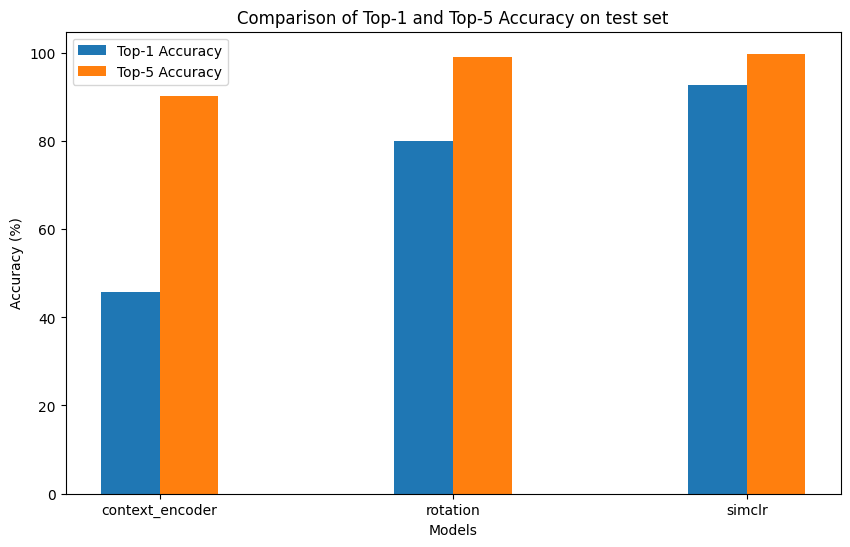

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(type_models))

# Plot bars for each accuracy metric
for i, metric in enumerate(df_test.index):
    ax.bar(index + i * bar_width, df_test.loc[metric], bar_width, label=metric)

# Labeling
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparison of Top-1 and Top-5 Accuracy on test set')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_test.columns)
ax.legend()

# Show plot
plt.show()


# Autre dataset SVHN


In [ ]:
from torchvision import datasets
from torchvision import transforms
import torch.utils.data as data
from deepul_helper.data import SimCLRDataTransform
import os.path as osp

def get_transform(dataset, task , train=True):
  transform = None
  if task == 'context_encoder':
    if dataset == 'svhn':
      transform = transforms.Compose([
          transforms.Resize(128),
          transforms.ToTensor(),
          transforms.Normalize((0.4379, 0.4438, 0.4728), (0.198, 0.201, 0.197))
      ])
  elif task == 'rotation':
    if dataset == 'svhn':
      if train:
        transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4379, 0.4438, 0.4728), (0.198, 0.201, 0.197))
        ])
      else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4379, 0.4438, 0.4728), (0.198, 0.201, 0.197))
        ])
  elif task == 'simclr':
    if dataset == 'svhn':
      if train:
        transform = transforms.Compose([
            transforms.RandomResizedCrop(32),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.4379, 0.4438, 0.4728], [0.198, 0.201, 0.197])
        ])
      else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.4379, 0.4438, 0.4728], [0.198, 0.201, 0.197])
        ])
    transform = SimCLRDataTransform(transform)

  return transform

def get_datasets_svhn(dataset, task):
  train_dset = datasets.SVHN(osp.join('data', dataset), split='train',
                                      transform=get_transform(dataset, task, train=True),
                                      download=True)
  test_dset = datasets.SVHN(osp.join('data', dataset), split='test',
                                     transform=get_transform(dataset, task, train=False),
                                     download=True)
  return train_dset, test_dset

In [ ]:
train_scores, test_scores = [], []

type_models = ['context_encoder', 'rotation', 'simclr']
for type_model in type_models:
    model, linear_classifier, _ , _ = load_model_and_data(type_model)
    # Get another dataset
    train_svhn, test_svhn = get_datasets_svhn(dataset='svhn', task = type_model)
    train_loader_svhn = data.DataLoader(train_svhn, batch_size=128, num_workers=4,
                                      pin_memory=True, shuffle=True)
    test_loader_svhn = data.DataLoader(test_svhn, batch_size=128, num_workers=4,
                                  pin_memory=True, shuffle=True)
    # Get scores
    train_acc1, train_acc5 = evaluate_classifier(model, linear_classifier, train_loader_svhn)
    train_scores.append((train_acc1, train_acc5))

    test_acc1, test_acc5 = evaluate_classifier(model, linear_classifier, test_loader_svhn)
    test_scores.append((test_acc1, test_acc5))

print(train_scores)
print(test_scores)

Files already downloaded and verified
Files already downloaded and verified


/content/cs294-158-ssl/deepul_helper/demos.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_pth, map_location='cpu')


100%|██████████| 182M/182M [00:29<00:00, 6.13MB/s]


100%|██████████| 64.3M/64.3M [00:12<00:00, 4.97MB/s]


Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
[(11.596161459103387, 50.8470180332917), (14.054629592206064, 50.91936606735445), (12.913441718775962, 51.724749852839764)]
[(11.674093423478796, 50.829748002458516), (14.209434541515874, 50.53779962887849), (11.885371848858421, 51.44437615008316)]


                context_encoder   rotation     simclr
Top-1 Accuracy        11.674093  14.209435  11.885372
Top-5 Accuracy        50.829748  50.537800  51.444376


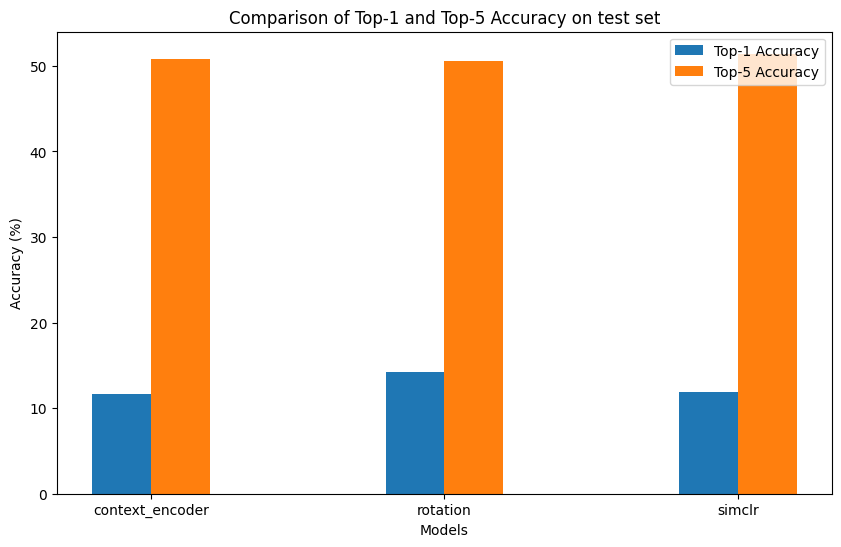

In [ ]:
train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

test_acc = {
    'context_encoder': test_scores[0],
    'rotation': test_scores[1],
    'simclr': test_scores[2]
}

index_labels = ['Top-1 Accuracy', 'Top-5 Accuracy']
df_test = pd.DataFrame(test_acc, index = index_labels)
print(df_test)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(type_models))

# Plot bars for each accuracy metric
for i, metric in enumerate(df_test.index):
    ax.bar(index + i * bar_width, df_test.loc[metric], bar_width, label=metric)

# Labeling
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparison of Top-1 and Top-5 Accuracy on test set')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_test.columns)
ax.legend()

# Show plot
plt.show()

# Prédire la position relative d’un patch de l’image relativement à un patch requête
The code is based and copy from : https://github.com/abhisheksambyal/Self-supervised-learning-by-context-prediction/tree/master

In [ ]:
!pip install wget
import os
import wget
import zipfile

data_dir = 'data/tiny-imagenet-200'
os.makedirs(data_dir, exist_ok=True)
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
dataset_path = os.path.join(data_dir, 'tiny-imagenet-200.zip')
wget.download(url, dataset_path)
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
  zip_ref.extractall(data_dir)
os.remove(dataset_path)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=727ff51db647bb6044c16242866ac9e58237c49f2bd6851a72c81e1d203719b1
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
from skimage import io, transform
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import datasets
from torchvision import transforms
import os.path as osp


class GetPatches(object):
    def __init__(self, patch_dim, gap):
        self.patch_dim, self.gap = patch_dim, gap

    def __call__(self, sample):
        image = np.array(sample)

        offset_x, offset_y = image.shape[0] - (self.patch_dim * 3 + self.gap * 2), image.shape[1] - (self.patch_dim * 3 + self.gap * 2)
        start_grid_x, start_grid_y = np.random.randint( 0, offset_x), np.random.randint(0, offset_y)
        patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)]
        loc = np.random.randint(len(patch_loc_arr))
        tempx, tempy = patch_loc_arr[loc]

        patch_x_pt = start_grid_x + self.patch_dim * (tempx - 1) + self.gap * (tempx - 1)
        patch_y_pt = start_grid_y + self.patch_dim * (tempy - 1) + self.gap * (tempy - 1)
        random_patch = image[patch_x_pt:patch_x_pt + self.patch_dim, patch_y_pt:patch_y_pt + self.patch_dim]

        patch_x_pt = start_grid_x + self.patch_dim + self.gap
        patch_y_pt = start_grid_y + self.patch_dim + self.gap
        uniform_patch = image[patch_x_pt:patch_x_pt + self.patch_dim, patch_y_pt:patch_y_pt + self.patch_dim]

        random_patch_label = loc

        if uniform_patch.shape[0] != 96:
            uniform_patch = transform.resize(uniform_patch, (96, 96))
            random_patch = transform.resize(random_patch, (96, 96))

        return uniform_patch, random_patch, random_patch_label


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        uniform_patch = sample[0].transpose((2, 0, 1))
        random_patch = sample[1].transpose((2, 0, 1))

        return uniform_patch, random_patch, sample[2]

In [4]:
def get_transform_patch(dataset, path_dim, gap):
  if dataset == 'cifar10':
    transform = transforms.Compose([GetPatches(path_dim, gap),
                             ToTensor()
                            ])
  return transform

In [5]:
path_dim = 9 # For CIFAR10 images
gap = 1
train_ds = datasets.CIFAR10(osp.join('data', 'cifar10'), train=True,
                                      transform=get_transform_patch('cifar10', path_dim, gap),
                                      download=True)

test_ds = datasets.CIFAR10(osp.join('data', 'cifar10'), train=False,
                                      transform=get_transform_patch('cifar10', path_dim, gap),
                                      download=True)

train_loader = data.DataLoader(train_ds, batch_size=128, num_workers=4,
                                      pin_memory=True, shuffle=True)
test_loader = data.DataLoader(train_ds, batch_size=128, num_workers=4,
                                      pin_memory=True, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
class AlexNetwork(nn.Module):
    def __init__(self, aux_logits=False):
        super(AlexNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=5, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(96),
            nn.Conv2d(96, 384, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(384),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.fc6 = nn.Sequential(
            nn.Linear(256, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
        )
        self.fc = nn.Sequential(nn.Linear(2 * 4096, 4096),
                                nn.ReLU(inplace=True), nn.Linear(4096, 4096),
                                nn.ReLU(inplace=True), nn.Linear(4096, 8))

    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc6(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = torch.cat((output1, output2), 1)
        output = self.fc(output)
        return output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlexNetwork().to(device)

In [7]:
l_r = 1e-2

optimizer = optim.Adam(model.parameters(), lr=l_r)
criterion = nn.CrossEntropyLoss()

num_epochs = 5

In [10]:
from pathlib import Path
Path(os.path.join('results','patch_prediction')).mkdir(parents=True, exist_ok=True)

In [13]:
import time
import numpy as np
from torch.autograd import Variable

global_trn_loss = []
global_val_loss = []

for epoch in range(num_epochs):
    train_running_loss = []
    val_running_loss = []
    start_time = time.time()
    model.train()
    for idx, (data, _) in enumerate(train_loader):
        image1 = torch.from_numpy(np.array(data[0])).float().to(device)
        image2 = torch.from_numpy(np.array(data[1])).float().to(device)
        label = torch.from_numpy(np.array(data[2])).long().to(device)

        output = model(image1, image2)
        loss = criterion(output, label)
        train_running_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    else:
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
          for idx, (data, _) in enumerate(test_loader):
            image1 = torch.from_numpy(np.array(data[0])).float().to(device)
            image2 = torch.from_numpy(np.array(data[1])).float().to(device)
            label = torch.from_numpy(np.array(data[2])).long().to(device)

            output = model(image1, image2)
            loss = criterion(output, label)
            val_running_loss.append(loss.item())

            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum()
          print('Val Progress --- total:{}, correct:{}'.format(total, correct.item()))
          print('Val Accuracy of the network on the 10000 test images: {}%'.format(100 * correct / total))
    global_trn_loss.append(sum(train_running_loss) / len(train_running_loss))
    global_val_loss.append(sum(val_running_loss) / len(val_running_loss))

    print('Epoch [{}/{}], TRNLoss:{}, Time:{:.2f}'.format(
        epoch + 1, num_epochs, global_trn_loss[-1],
        (time.time() - start_time) / 60))

    if epoch % 5 == 0:
      MODEL_SAVE_PATH = os.path.join('results','patch_prediction', 'cifar10' + str(epoch))
      torch.save(
        {
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'global_trnloss': global_trn_loss,
            'global_valloss': global_val_loss
        }, MODEL_SAVE_PATH)

Val Progress --- total:50000, correct:6333
Val Accuracy of the network on the 10000 test images: 12.665999412536621%
Epoch [1/5], TRNLoss:2.0798360301405574, Time:8.64
Val Progress --- total:50000, correct:6160
Val Accuracy of the network on the 10000 test images: 12.319999694824219%
Epoch [2/5], TRNLoss:2.0800154087183724, Time:8.83
Val Progress --- total:50000, correct:6128
Val Accuracy of the network on the 10000 test images: 12.255999565124512%
Epoch [3/5], TRNLoss:2.0801028656532696, Time:8.74
Val Progress --- total:50000, correct:6268
Val Accuracy of the network on the 10000 test images: 12.535999298095703%
Epoch [4/5], TRNLoss:2.080144250484379, Time:8.52
Val Progress --- total:50000, correct:6238
Val Accuracy of the network on the 10000 test images: 12.47599983215332%
Epoch [5/5], TRNLoss:2.0800230698207454, Time:8.38
